In [30]:
#########################################
# 1) IMPORTS
#########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Splitting & Cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

# Scaling
from sklearn.preprocessing import StandardScaler

# Import the featured dataset

In [3]:
# Import dataset
original_dataset = pd.read_csv('/home/jovyan/work/data/prepared_dataset.csv', index_col=0)

In [4]:
# sci-kit learn libraries
from sklearn.model_selection import train_test_split

# Split Dataset 

In [8]:
# 🔹 Step 5: Splitting the Dataset into Train and Test Sets (Stratified)
train_set, test_set = train_test_split(
    original_dataset,
    test_size=0.2,
    random_state=42,
    stratify=original_dataset['target']  # Key line for classification
)

# Display the final datasets
display(train_set.head())
display(test_set.head())

,sex,weight,height,resting.bp.s,cholesterol,fasting.blood.sugar,physical_activity,age,ST.slope,chest.pain.type,exercise.angina,max.heart.rate,oldpeak,resting.ecg,target
360,1,98.2,171.0,105,0,0,0,54,2.0,3.0,0.0,115.0,0.0,0.0,1
842,1,83.0,166.0,135,203,0,0,42,2.0,2.0,0.0,132.0,0.0,0.0,0
54,0,95.8,201.0,130,180,0,2,53,2.0,4.0,1.0,140.0,1.5,0.0,0
528,1,80.5,146.0,139,283,0,1,62,1.0,2.0,0.0,135.0,0.3,0.0,0
969,1,57.4,165.0,140,321,0,0,40,1.0,3.0,0.0,182.0,0.0,2.0,0


,sex,weight,height,resting.bp.s,cholesterol,fasting.blood.sugar,physical_activity,age,ST.slope,chest.pain.type,exercise.angina,max.heart.rate,oldpeak,resting.ecg,target
369,1,96.6,157.0,140,0,0,1,58,2.0,4.0,1.0,120.0,2.0,0.0,1
1089,1,58.9,167.0,150,126,1,0,58,1.0,3.0,0.0,173.0,0.2,0.0,0
305,1,71.0,172.0,95,0,1,1,52,2.0,4.0,0.0,126.0,2.2,0.0,1
770,0,61.3,168.0,130,303,0,0,65,2.0,4.0,0.0,122.0,2.0,0.0,0
259,0,61.2,191.0,150,200,0,0,52,1.0,3.0,0.0,120.0,0.5,0.0,0


In [9]:
# Define your target column
target_column = "target"

# Training set: separate features and target
X_train = train_set.drop(columns=[target_column])
y_train = train_set[target_column]

# Test set: separate features and target
X_test = test_set.drop(columns=[target_column])
y_test = test_set[target_column]

In [11]:
# Scaling features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
%run utilities.ipynb

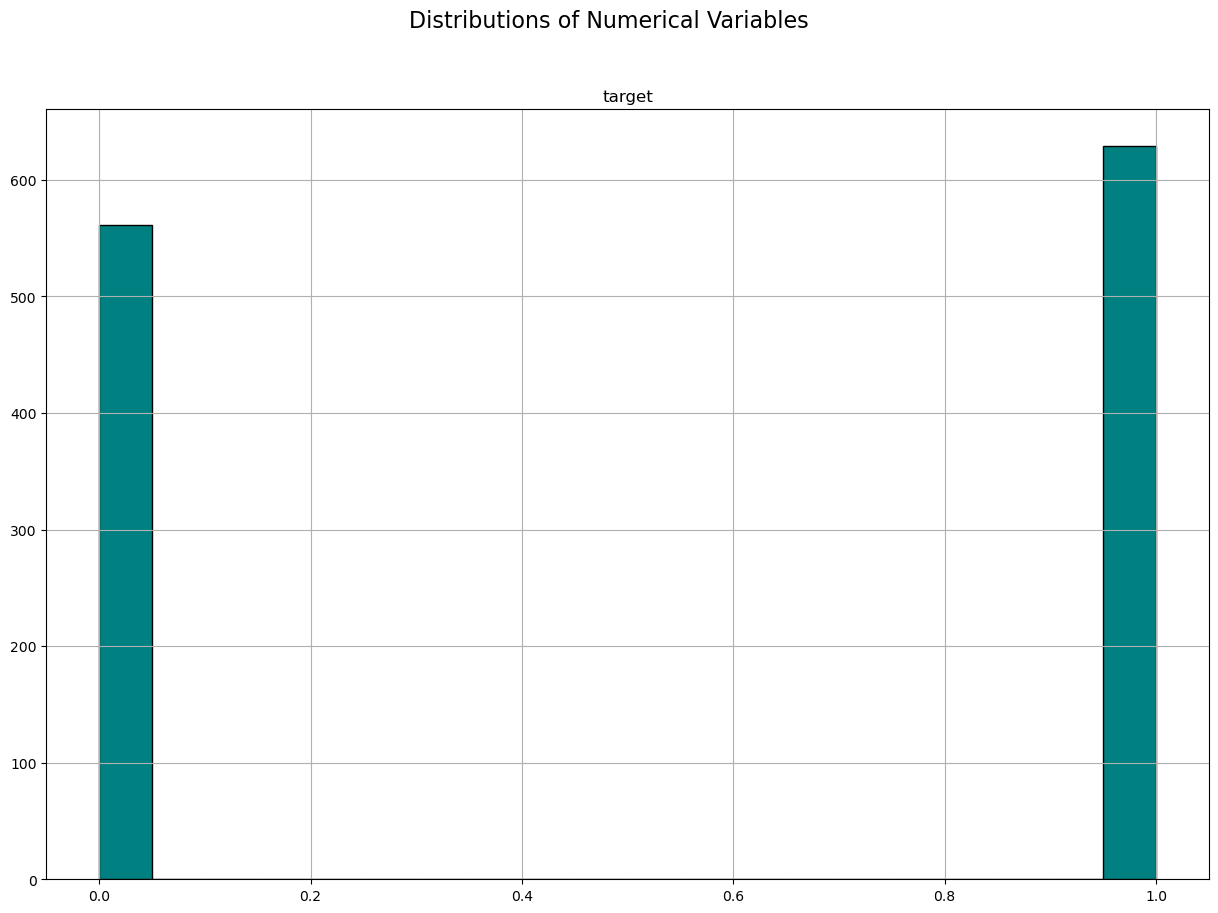

In [18]:
# check balancing of target features
plot_numerical_distributions(original_dataset, numerical_vars=['target'])

# Models training

===== BASELINE CROSS-VALIDATION (ROC AUC) =====
LogisticRegression -> Mean ROC AUC: 0.897 (Std: 0.020)


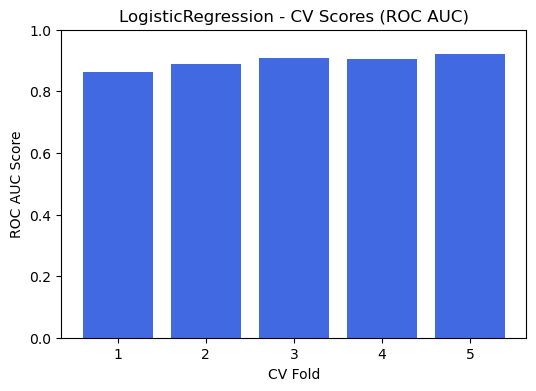

RandomForest -> Mean ROC AUC: 0.935 (Std: 0.016)


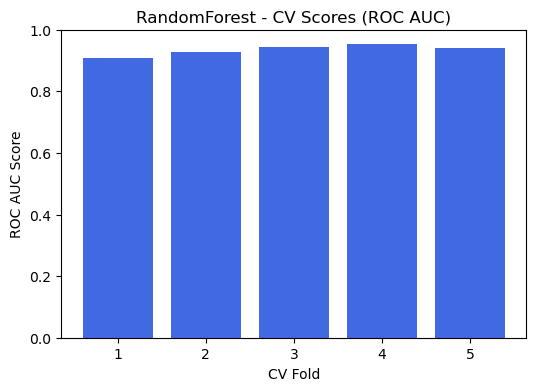

SVC -> Mean ROC AUC: 0.913 (Std: 0.017)


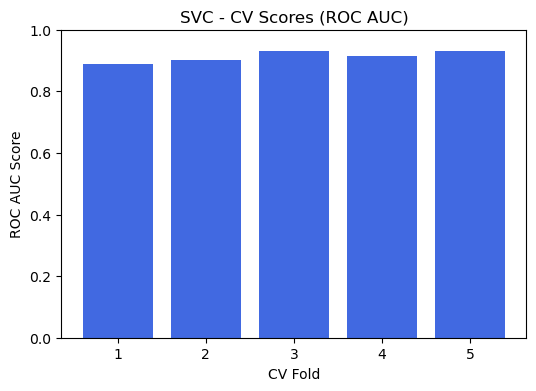

In [31]:
#########################################
# 3) BASELINE MODELS & CROSS-VALIDATION
#########################################

# Instantiate models
models = [
    ("LogisticRegression", LogisticRegression(random_state=42)),
    ("RandomForest", RandomForestClassifier(random_state=42)),
    ("SVC", SVC(probability=True, random_state=42))  # 'probability=True' needed for predict_proba
]

print("===== BASELINE CROSS-VALIDATION (ROC AUC) =====")
for name, model in models:
    cv_scores = cross_val_score(
        model,
        X_train_scaled,   # scaled data
        y_train,
        cv=5,
        scoring='roc_auc'
    )
    print(f"{name} -> Mean ROC AUC: {cv_scores.mean():.3f} (Std: {cv_scores.std():.3f})")
    
    # Visualize the CV scores per fold
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='royalblue')
    plt.xlabel('CV Fold')
    plt.ylabel('ROC AUC Score')
    plt.title(f'{name} - CV Scores (ROC AUC)')
    plt.ylim([0, 1])
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.show()

# HYPERPARAMETER TUNING

In [32]:
#########################################
# 4) HYPERPARAMETER TUNING (GRID SEARCH)
#########################################

# --- Logistic Regression ---
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [100, 200, 300]
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_search_lr.fit(X_train_scaled, y_train)

print("\n===== LOGISTIC REGRESSION RESULTS =====")
print("Best params (LogisticRegression):", grid_search_lr.best_params_)
print(f"Best CV ROC AUC: {grid_search_lr.best_score_:.3f}")
best_lr = grid_search_lr.best_estimator_

# --- Random Forest ---
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_search_rf.fit(X_train_scaled, y_train)

print("\n===== RANDOM FOREST RESULTS =====")
print("Best params (RandomForest):", grid_search_rf.best_params_)
print(f"Best CV ROC AUC: {grid_search_rf.best_score_:.3f}")
best_rf = grid_search_rf.best_estimator_

# --- SVC ---
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svc,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_search_svc.fit(X_train_scaled, y_train)

print("\n===== SVC RESULTS =====")
print("Best params (SVC):", grid_search_svc.best_params_)
print(f"Best CV ROC AUC: {grid_search_svc.best_score_:.3f}")
best_svc = grid_search_svc.best_estimator_


===== LOGISTIC REGRESSION RESULTS =====
Best params (LogisticRegression): {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}
Best CV ROC AUC: 0.899

===== RANDOM FOREST RESULTS =====
Best params (RandomForest): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best CV ROC AUC: 0.937

===== SVC RESULTS =====
Best params (SVC): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV ROC AUC: 0.914


# Model evaluation 


===== TEST SET EVALUATION =====

--- LogisticRegression ---
Test ROC AUC: 0.906
Confusion Matrix:
 [[ 91  21]
 [ 19 107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       112
           1       0.84      0.85      0.84       126

    accuracy                           0.83       238
   macro avg       0.83      0.83      0.83       238
weighted avg       0.83      0.83      0.83       238


--- RandomForest ---
Test ROC AUC: 0.961
Confusion Matrix:
 [[102  10]
 [ 10 116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       112
           1       0.92      0.92      0.92       126

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238


--- SVC ---
Test ROC AUC: 0.936
Confusion Matrix:
 [[ 95  17]
 [ 12 114]]
Classification R

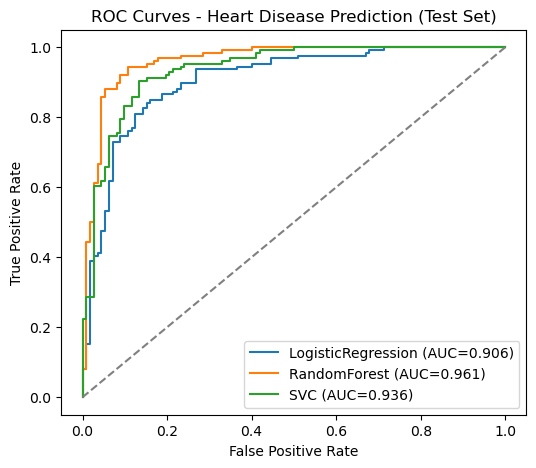

In [33]:
#########################################
# 5) EVALUATE EACH BEST MODEL ON TEST SET
#########################################

models_best = [
    ("LogisticRegression", best_lr),
    ("RandomForest", best_rf),
    ("SVC", best_svc)
]

print("\n===== TEST SET EVALUATION =====")
model_scores = []
plt.figure(figsize=(6, 5))

for name, model in models_best:
    # Probability of the positive class (for ROC AUC)
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba_test)
    
    # Collect for final comparison
    model_scores.append((name, roc_auc))
    
    # Plot ROC curve for each model
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

    print(f"\n--- {name} ---")
    print(f"Test ROC AUC: {roc_auc:.3f}")
    
    # Get classification metrics at the default threshold (0.5)
    y_pred_test = model.predict(X_test_scaled)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Finalize the ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Heart Disease Prediction (Test Set)")
plt.legend()
plt.show()

## **📊 Business Insights on Heart Disease Prediction**
### **🚀 Model Performance Highlights:**
- **High Predictive Power:**  
  All models have **AUC scores above 0.90**, showcasing **strong diagnostic capability**.
  
- **🔝 Random Forest Excels:**  
  With an **AUC of 96.1%**, it is the **most accurate** model for predicting heart disease.

### **💡 Potential Use in Healthcare:**
#### **1️⃣ Early Detection**
   - **Flag high-risk patients** for further medical evaluation.  
   - Enables **proactive interventions** to reduce complications.

#### **2️⃣ Preventative Interventions**
   - Recommend **lifestyle changes** or **medications** **before symptoms worsen**.  
   - Helps in **reducing long-term healthcare costs**.

#### **3️⃣ Optimized Resource Allocation**
   - **Prioritize high-risk patients** for faster treatment.  
   - Improves **hospital efficiency** and **patient outcomes**.

---

# Model saving

In [34]:
import os
import joblib
from datetime import datetime

#########################################
# 6) COMPARE & SAVE THE BEST MODEL
#########################################

# Pick the model with the highest ROC AUC
model_scores.sort(key=lambda x: x[1], reverse=True)
best_model_name, best_model_score = model_scores[0]

print("\n===== BEST MODEL =====")
print(f"Model: {best_model_name} with Test ROC AUC = {best_model_score:.3f}")

# Retrieve the actual model object
best_model_object = dict(models_best)[best_model_name]


===== BEST MODEL =====
Model: RandomForest with Test ROC AUC = 0.961


In [36]:
# Create a dynamic filename (e.g., "RandomForest_20250128_153045.pkl")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dynamic_filename = f"{best_model_name}_{timestamp}.pkl"

# Define the folder path where you want to save the model
folder_path = "/home/jovyan/work/models"

# Construct the full path
save_model_path = os.path.join(folder_path, dynamic_filename)

# Save the model to disk
joblib.dump(best_model_object, save_model_path)
print(f"Saved the best model ({best_model_name}) to '{save_model_path}'")

Saved the best model (RandomForest) to '/home/jovyan/work/models/RandomForest_20250129_154514.pkl'


# Recommandations
- add metric scoring in the discussion with the business (example: use precision or recall for true/false positive rate)
- add weight for features
- search the best variables for the model training